# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [0]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [0]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter, mode='same')
filterResponseSobelX = signal.convolve2d(image, sobelX, mode='same')
filterResponseSobelY = signal.convolve2d(image, sobelY, mode='same')

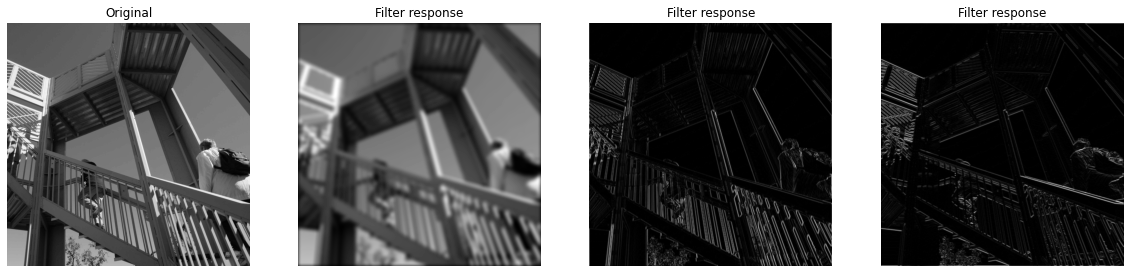

In [0]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

Question 3: What is the size of the different filters?

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?


Ans 1: Gaussian filter performs the pixel pulvering(blurring) of an input image. The sobelX and sobelY filters are used to perform edge detection along X and Y axes respectively.

Ans 2: The size of the original image is 512 X 512. The image is a greyscale image, it has one channel. Colour image normally has 3 channels.

Ans 3: The size of gaussian filter is 15 X 15. The size of SobelX and SobelY is 3 X 3.

Ans 4: The size of filter response in the 'same' mode is the same size of an original image.

Ans 5: The size of the filter response if 'valid' mode is used is equal to or less than the size of the original image. The size of the filter will is same as the size of each patch from the original image on which the convolution is performed. Hence the size of response will always be a multiple of the size of the filter.

Ans 6: The 'valid' convolution may result in loss of some pixels from the image based on the size of filter. So when the convolution is performed on multiple layers, it might lose a lot of image data. 


In [0]:
# Your code for checking sizes of image and filter responses
print("The size of image:",np.shape(image))
print("The size of Gaussian filter response :",np.shape(filterResponseGauss))
print("The size of sobelX:", np.shape(filterResponseSobelX))
print("The size of SobelY:", np.shape(filterResponseSobelY))



The size of image: (512, 512)
The size of Gaussian filter response : (512, 512)
The size of sobelX: (512, 512)
The size of SobelY: (512, 512)


##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [0]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

Ans 7: The size of filters is of size 7 X 7 X 3 as each colour image has 3 channels (R,G,B).

Ans 8: Conv2D layer creates a convolution matrix that can be used to perform different operations on the image such as blurring, edge detection, sharpening etc by performing convolution over the image using this convolution matrix. 
the standard 2D convolution is performed on an image using a single filter. However, in the Conv2D layer, a number of filters are applied on an input image to produce the output tensors.

Ans 9: The GPU is 62X faster than the CPUfor convolving a batch of 100 images.

Ans 10: The GPU is 2X faster than CPU for convolving a batch of 2 images. It is much on CPU to perform the convolution over 100 images as compared to 2 images.

In [0]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.1303025949999892
GPU (s):
0.061523528000009264
GPU speedup over CPU: 2x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [0]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

170500096/170498071 [==============================] - 11s 0us/step
Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

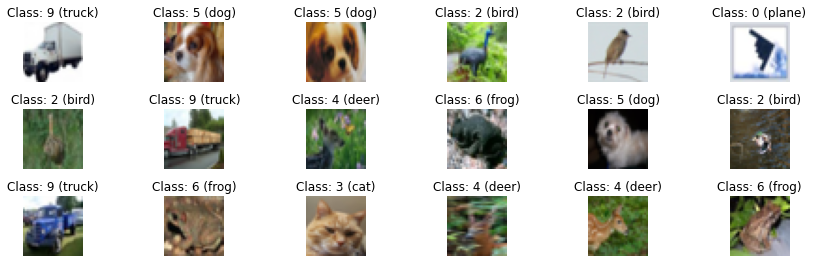

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [0]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain,Ytrain, test_size = 0.25)

# Print the size of training data, validation data and test data
print(np.shape(Xtrain))
print(np.shape(Xval))
print(np.shape(Xtest))

(7500, 32, 32, 3)
(2500, 32, 32, 3)
(2000, 32, 32, 3)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [0]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [0]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print(np.shape(Ytrain))
print(np.shape(Yval))
print(np.shape(Ytest))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain_c = to_categorical(Ytrain)
Yval_c = to_categorical(Yval)
Ytest_c = to_categorical(Ytest)
# Print shapes after converting the labels

print("output:",np.shape(Ytrain_c))
print("output:",np.shape(Yval_c))
print("output:",np.shape(Ytest_c))

(7500, 1)
(2500, 1)
(2000, 1)
output: (7500, 10)
output: (2500, 10)
output: (2000, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    
    opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(n_filters, (3,3), input_shape = input_shape, activation='relu', padding='same'))
    model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                    center=True, scale=True, beta_initializer='zeros',
                                    gamma_initializer='ones', moving_mean_initializer='zeros',
                                    moving_variance_initializer='ones', beta_regularizer=None,
                                    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
      model.add(Conv2D((n_filters*(2**(i+1))), (3,3),activation='relu', padding='same'))
      model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                    center=True, scale=True, beta_initializer='zeros',
                                    gamma_initializer='ones', moving_mean_initializer='zeros',
                                    moving_variance_initializer='ones', beta_regularizer=None,
                                    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      

    
    # Add flatten layer
    model.add(Flatten())
    
    # Add intermediate dense layers
    for i in range(n_dense_layers):
      model.add(Dense(n_nodes, activation='relu'))
      if (use_dropout==True):
        model.add(Dropout(0.5))
      model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                    center=True, scale=True, beta_initializer='zeros',
                                    gamma_initializer='ones', moving_mean_initializer='zeros',
                                    moving_variance_initializer='ones', beta_regularizer=None,
                                    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)) 
        
    # Add final dense layer
    model.add(Dense(10, activation='softmax'))
   
    # Compile model
    model.compile(loss = 'categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    return model

In [0]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

In [0]:
Xtrain.shape[1:]

(32, 32, 3)

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model1 =  build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain,Ytrain_c,validation_data = (Xval, Yval_c),batch_size = batch_size, epochs = epochs)
#plot_results(history1)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 1s 175us/step - loss: 3.0016 - accuracy: 0.3109 - val_loss: 2.0741 - val_accuracy: 0.3164
Epoch 2/20
7500/7500 [==============================] - 1s 95us/step - loss: 1.5832 - accuracy: 0.4671 - val_loss: 1.7445 - val_accuracy: 0.3776
Epoch 3/20
7500/7500 [==============================] - 1s 94us/step - loss: 1.2520 - accuracy: 0.5573 - val_loss: 1.6504 - val_accuracy: 0.4180
Epoch 4/20
7500/7500 [==============================] - 1s 91us/step - loss: 1.1316 - accuracy: 0.5939 - val_loss: 1.3714 - val_accuracy: 0.5076
Epoch 5/20
7500/7500 [==============================] - 1s 91us/step - loss: 1.0041 - accuracy: 0.6428 - val_loss: 1.4384 - val_accuracy: 0.4824
Epoch 6/20
7500/7500 [==============================] - 1s 93us/step - loss: 0.9071 - accuracy: 0.6788 - val_loss: 1.3042 - val_accuracy: 0.5580
Epoch 7/20
7500/7500 [==============================] - 1s 90us/step - loss: 0.83

In [0]:
model1.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 97us/step
Test loss: 2.9281
Test accuracy: 0.5540


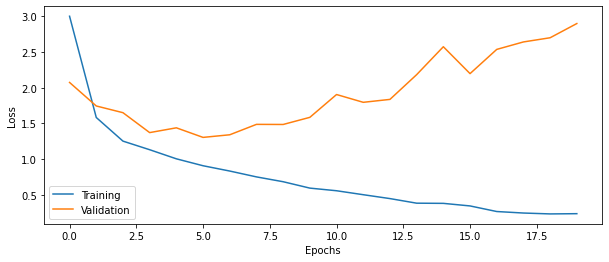

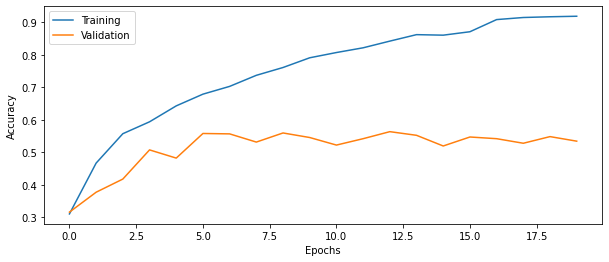

In [0]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 11: How big is the difference between training and test accuracy?

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

Ans 11: The training accuracy is as high as 0.81 and the test accuracy is 0.55

Ans 12: Google colab was used, so unable to compute.

Ans 13: The data in DNN laborations was just numbers so a large batch size could be computed much faster and multiple cores could accomodate the batch size. however, here we need to use a smaller batch size as the input data is an image which is a matrix which is larger, so a smaller batch size would still amount to same input vector length as in DNN input.

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model2 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain,Ytrain_c,validation_data = (Xval, Yval_c),batch_size = batch_size, epochs = epochs)
#plot_results(history1)

# Train the model  using training data and validation data
#history2 = 

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 1s 162us/step - loss: 1.6680 - accuracy: 0.3983 - val_loss: 2.1301 - val_accuracy: 0.2452
Epoch 2/20
7500/7500 [==============================] - 1s 102us/step - loss: 1.2588 - accuracy: 0.5457 - val_loss: 2.0659 - val_accuracy: 0.3120
Epoch 3/20
7500/7500 [==============================] - 1s 101us/step - loss: 1.0605 - accuracy: 0.6209 - val_loss: 1.6040 - val_accuracy: 0.4516
Epoch 4/20
7500/7500 [==============================] - 1s 101us/step - loss: 0.8636 - accuracy: 0.6968 - val_loss: 1.3786 - val_accuracy: 0.5380
Epoch 5/20
7500/7500 [==============================] - 1s 100us/step - loss: 0.7300 - accuracy: 0.7387 - val_loss: 1.4894 - val_accuracy: 0.5536
Epoch 6/20
7500/7500 [==============================] - 1s 100us/step - loss: 0.5567 - accuracy: 0.8087 - val_loss: 1.4578 - val_accuracy: 0.5604
Epoch 7/20
7500/7500 [==============================] - 1s 100us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest, Ytest_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 93us/step
Test loss: 2.9691
Test accuracy: 0.5655


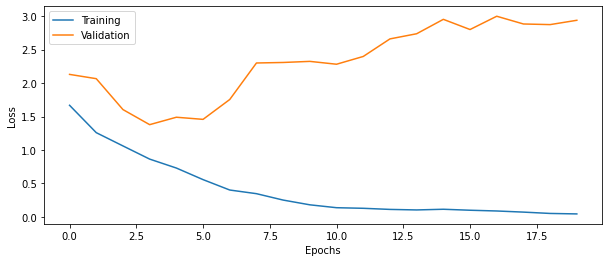

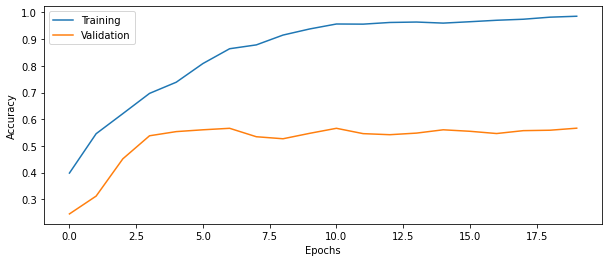

In [0]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model3 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain,Ytrain_c,validation_data = (Xval, Yval_c),batch_size = batch_size, epochs = epochs)

# Train the model  using training data and validation data
#history3 = 

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 245us/step - loss: 1.7040 - accuracy: 0.3865 - val_loss: 1.8086 - val_accuracy: 0.3604
Epoch 2/20
7500/7500 [==============================] - 1s 134us/step - loss: 1.3559 - accuracy: 0.5037 - val_loss: 2.1166 - val_accuracy: 0.2992
Epoch 3/20
7500/7500 [==============================] - 1s 135us/step - loss: 1.1507 - accuracy: 0.5807 - val_loss: 1.3499 - val_accuracy: 0.5272
Epoch 4/20
7500/7500 [==============================] - 1s 134us/step - loss: 0.9930 - accuracy: 0.6423 - val_loss: 1.4219 - val_accuracy: 0.5436
Epoch 5/20
7500/7500 [==============================] - 1s 131us/step - loss: 0.8308 - accuracy: 0.7031 - val_loss: 1.6655 - val_accuracy: 0.5456
Epoch 6/20
7500/7500 [==============================] - 1s 132us/step - loss: 0.6808 - accuracy: 0.7583 - val_loss: 1.7190 - val_accuracy: 0.5496
Epoch 7/20
7500/7500 [==============================] - 1s 132us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest, Ytest_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 116us/step
Test loss: 2.5231
Test accuracy: 0.5825


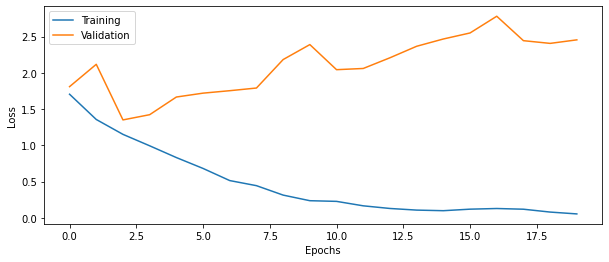

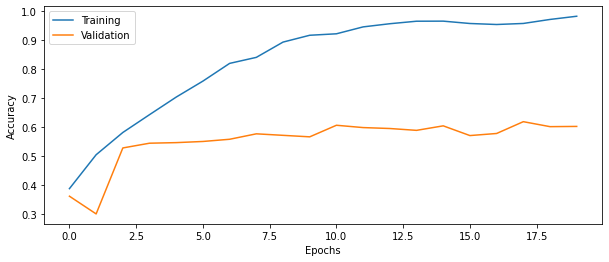

In [0]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

Question 19: How does MaxPooling help in reducing the number of parameters to train?

Ans 14: The number of trainable parameters are 124,180. The 4th convolutional layers has the most number of parameters.

Ans 15: The input and output both to the conv2D layer is a 4D tensor (batch_size, channels, new_rows, new_cols) and (batch_size, filters, new_rows, new_cols) respectively.

Ans 16: Yes, batch size is always the first dimension of each 4D tensor.

Ans 17: number of channels in the output is 128.

Ans 18: Along with the number of filter coefficients, the no. of parameters also depend on the the number of channels present in the input and the output as, the convolution is applied on each channel.

Ans 19: Maxpooling takes the maximum value from each stride, thus for a stride of 2 x 2, it will take one max value 1 X 1 from that stride and reduces the dimensionality of the image and the parameters to train.


In [0]:
# Print network architecture

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)         

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?


Ans 20: The test accuracy increased from 0.58 to 0.60 after adding the dropout.

Ans 21: The other different types of regularization is L1 class, L2 class, L1 L2 function etc. 
The l2 regularization can be added using
 tf.keras.regularizers.l2(l2=0.01, **kwargs)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model4 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain,Ytrain_c,validation_data = (Xval, Yval_c),batch_size = batch_size, epochs = epochs)


# Train the model  using training data and validation data
#history4 = 

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 243us/step - loss: 1.9210 - accuracy: 0.2976 - val_loss: 1.7319 - val_accuracy: 0.3492
Epoch 2/20
7500/7500 [==============================] - 1s 132us/step - loss: 1.5751 - accuracy: 0.4129 - val_loss: 1.9073 - val_accuracy: 0.3080
Epoch 3/20
7500/7500 [==============================] - 1s 133us/step - loss: 1.4413 - accuracy: 0.4621 - val_loss: 1.5594 - val_accuracy: 0.4076
Epoch 4/20
7500/7500 [==============================] - 1s 130us/step - loss: 1.3323 - accuracy: 0.5096 - val_loss: 1.3193 - val_accuracy: 0.5228
Epoch 5/20
7500/7500 [==============================] - 1s 133us/step - loss: 1.2118 - accuracy: 0.5579 - val_loss: 1.3251 - val_accuracy: 0.5336
Epoch 6/20
7500/7500 [==============================] - 1s 134us/step - loss: 1.1217 - accuracy: 0.5925 - val_loss: 1.3669 - val_accuracy: 0.5492
Epoch 7/20
7500/7500 [==============================] - 1s 132us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest, Ytest_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 113us/step
Test loss: 2.0999
Test accuracy: 0.6055


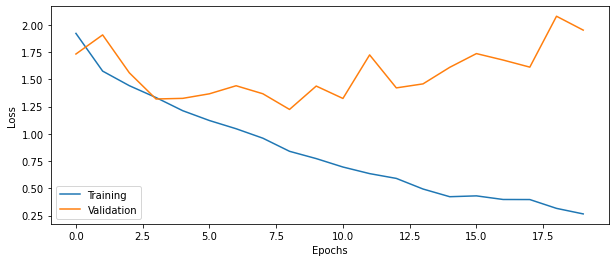

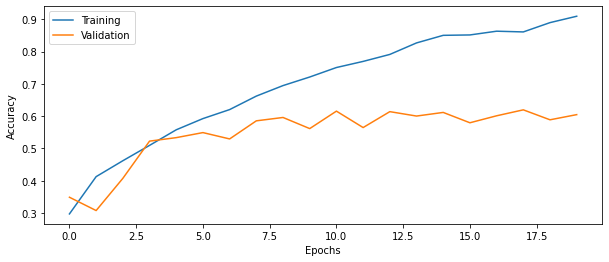

In [0]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?

Ans 22: The best configuration obtained is 
n_conv_layers=4,
n_filters=16,
n_dense_layers=1,
n_nodes=50
use_dropout = True

## Your best config

In [0]:
# Setup some training parameters

# Build model
model5 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history5 = model5.fit(Xtrain,Ytrain_c,validation_data = (Xval, Yval_c),batch_size = batch_size, epochs = epochs)



Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 248us/step - loss: 2.0052 - accuracy: 0.2724 - val_loss: 1.9620 - val_accuracy: 0.2808
Epoch 2/20
7500/7500 [==============================] - 1s 130us/step - loss: 1.6717 - accuracy: 0.3643 - val_loss: 1.9146 - val_accuracy: 0.3096
Epoch 3/20
7500/7500 [==============================] - 1s 131us/step - loss: 1.5313 - accuracy: 0.4272 - val_loss: 1.6253 - val_accuracy: 0.4248
Epoch 4/20
7500/7500 [==============================] - 1s 135us/step - loss: 1.4174 - accuracy: 0.4687 - val_loss: 1.3849 - val_accuracy: 0.5116
Epoch 5/20
7500/7500 [==============================] - 1s 133us/step - loss: 1.3210 - accuracy: 0.5084 - val_loss: 1.2707 - val_accuracy: 0.5372
Epoch 6/20
7500/7500 [==============================] - 1s 133us/step - loss: 1.2113 - accuracy: 0.5472 - val_loss: 1.3711 - val_accuracy: 0.5216
Epoch 7/20
7500/7500 [==============================] - 1s 136us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest, Ytest_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 104us/step
Test loss: 1.7962
Test accuracy: 0.5750


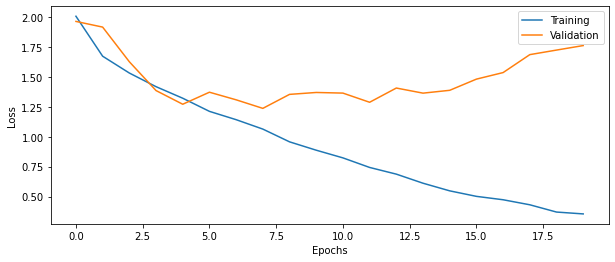

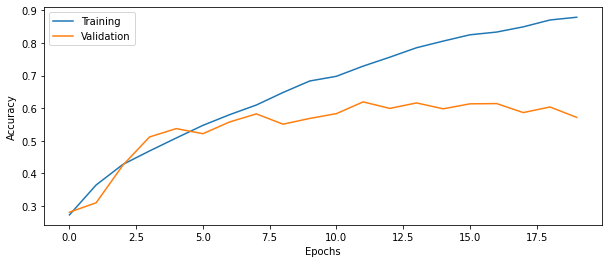

In [0]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

Ans 23: The test accuracy in case of rotated images is as low as 0.23 as compared to without rotation which has accuracy of 0.60. The reason could be that the training data used for the model did not include the augmented images.

In [0]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

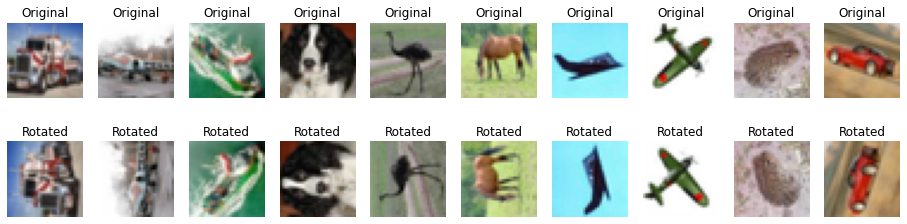

In [0]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [0]:
# Evaluate the trained model on rotated test set
score = model4.evaluate(Xtest_rotated, Ytest_c)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 127us/step
Test loss: 4.8701
Test accuracy: 0.2290


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [0]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain),_ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [0]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator



# Setup a flow for training data, assume that we can fit all images into CPU memory
datagen = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,   
)

datagen.fit(Xtrain)
traingen = datagen.flow(Xtrain, Ytrain, batch_size=100, subset="training")

# Setup a flow for validation data, assume that we can fit all images into CPU memory
validgen = datagen.flow(Xtrain, Ytrain, batch_size=100, subset="validation")

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

Ans 24: If all the training images cannot be fit in the CPU memory, 
ImageDataGenerator.flow_from_directory() is needed to load the data into the memory of CPU on the fly.
The disadvantage is that the pre processing of images will be more time consuming as the images are loaded from a directory in the memory.

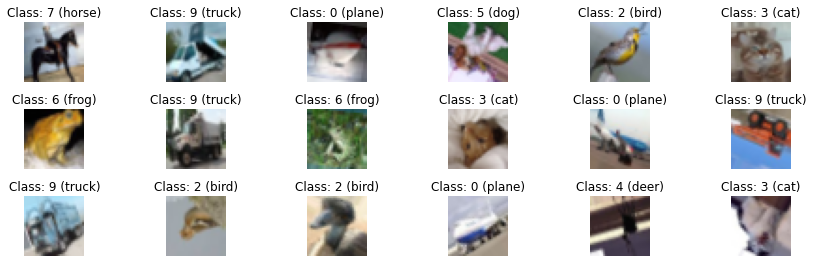

In [0]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

Question 26: What other types of image augmentation can be applied, compared to what we use here?

Ans 25: The accuracy increased from 0.57 to 0.66 after augmentation of the training data set. The reason for such a difference in accuracy is that, augmentation augments the training image by scaling, rotating, resizing so that when a tilted image or blurred test image is passed, the model can still recognize the image and label the output correctly. Without augmentation of the training images, the test images do not be able to classify correctly.
The Validation split paramter has to be modified in order to perform more training.

Ans 26: Other types of image augmentation can be Color space, Translation, Noise Injection, Mixing images, Random erasing.

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = Xtrain.shape[1:]

# Build model (your best config)
model6 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

validation_split=0.2
    
# Train the model using on the fly augmentation
history6 = model6.fit_generator(traingen, epochs=epochs,
                                           steps_per_epoch=len(Xtrain)*(1 - validation_split)/batch_size,
                                           validation_data=validgen,
                                           validation_steps=len(Xtrain)*validation_split/batch_size,
                                           use_multiprocessing=True)

Epoch 1/200
80/80 [==============================] - 5s 68ms/step - loss: 2.0711 - accuracy: 0.2451 - val_loss: 2.5920 - val_accuracy: 0.1840
Epoch 2/200
Epoch 1/200
80/80 [==============================] - 4s 51ms/step - loss: 1.8296 - accuracy: 0.3130 - val_loss: 2.2760 - val_accuracy: 0.2165
Epoch 3/200
80/80 [==============================] - 4s 51ms/step - loss: 1.7470 - accuracy: 0.3434 - val_loss: 1.7023 - val_accuracy: 0.3300
Epoch 4/200
80/80 [==============================] - 4s 51ms/step - loss: 1.6994 - accuracy: 0.3738 - val_loss: 1.6436 - val_accuracy: 0.3790
Epoch 5/200
80/80 [==============================] - 4s 51ms/step - loss: 1.6482 - accuracy: 0.3925 - val_loss: 1.5735 - val_accuracy: 0.4080
Epoch 6/200
80/80 [==============================] - 4s 51ms/step - loss: 1.6243 - accuracy: 0.3969 - val_loss: 1.5991 - val_accuracy: 0.4085
Epoch 7/200
80/80 [==============================] - 4s 52ms/step - loss: 1.5777 - accuracy: 0.4157 - val_loss: 1.5960 - val_accuracy: 0

In [0]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest_c, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest_c, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.1525
Test accuracy: 0.6605
Test loss: 3.0443
Test accuracy: 0.3170


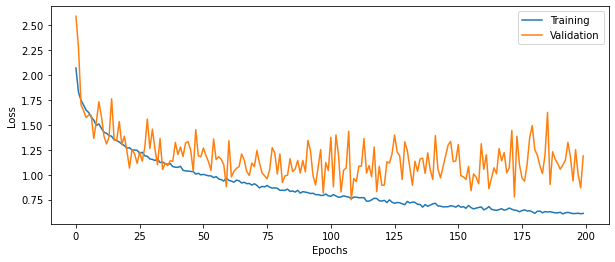

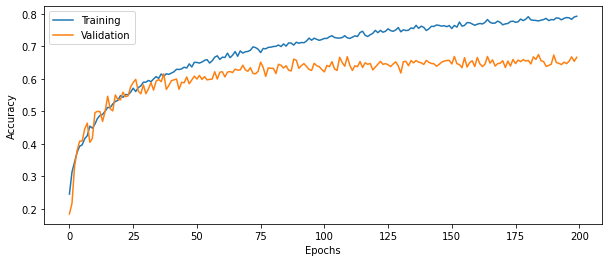

In [0]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [0]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest_c,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

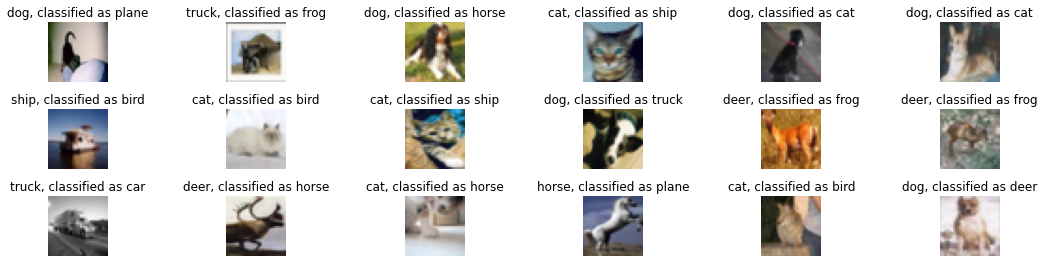

In [0]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

Ans 27: No, it is not directly possible to train different sized images because the CNN layers are defined based on the input size of the image, without having the input size of the image, the architecture cannot be defined.

Ans 28: The possible options that can be done are multi-scale training of images of different sizes in fully-convolutional nets in order to make the model more robust to changes in scale or having multi-scale architecture to handle changing image size.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

Question 30: How many trainable parameters does the ResNet50 network have? 

Question 31: What is the size of the images that ResNet50 expects as input?

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


Ans 29: There are 23 Convolutional layers in ResNet50.

Ans 30: Trainable params: 25,583,592

Ans 31: The size of input image can be of any dimension.

Ans 32: The second-order information are rarely used because of the computational cost and noise associated with the approaches in deep learning.

Out of 5 images, the ResNet model was able to classify correctly 2 images and 1 image with second proability score and remaining two with whole new different class.

In [5]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model_res = ResNet50(weights='imagenet')

img_path = '/content/car.jpeg'
img1 = image.load_img(img_path, target_size=(224, 224))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = preprocess_input(x1)

preds = model_res.predict(x1)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])





40960/35363 [==================================] - 0s 0us/step
Predicted: [('n04285008', 'sports_car', 0.49526885), ('n04037443', 'racer', 0.33890426), ('n02930766', 'cab', 0.090220705)]


In [0]:
print(model_res.summary())

In [6]:
img_path = '/content/cat.jpeg'
img1 = image.load_img(img_path, target_size=(224, 224))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = preprocess_input(x1)

preds = model_res.predict(x1)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n02110806', 'basenji', 0.158942), ('n02123159', 'tiger_cat', 0.09536588), ('n02115913', 'dhole', 0.0710836)]


In [7]:
img_path = '/content/Flower.jpeg'
img1 = image.load_img(img_path, target_size=(224, 224))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = preprocess_input(x1)

preds = model_res.predict(x1)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n04404412', 'television', 0.29692763), ('n03782006', 'monitor', 0.20672645), ('n04152593', 'screen', 0.1569845)]


In [9]:
img_path = '/content/Train.jpeg'
img1 = image.load_img(img_path, target_size=(224, 224))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = preprocess_input(x1)

preds = model_res.predict(x1)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n03895866', 'passenger_car', 0.57455444), ('n03272562', 'electric_locomotive', 0.4092769), ('n03393912', 'freight_car', 0.015388064)]


In [10]:
img_path = '/content/Aeroplane.jpeg'
img1 = image.load_img(img_path, target_size=(224, 224))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = preprocess_input(x1)

preds = model_res.predict(x1)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02690373', 'airliner', 0.92600846), ('n04592741', 'wing', 0.073143944), ('n04266014', 'space_shuttle', 0.00061710196)]
